# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


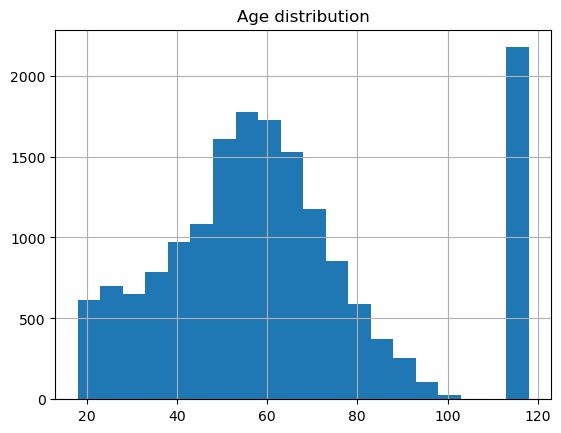

In [7]:
profile['age'].hist(bins=20)
plt.title('Age distribution')
plt.show()

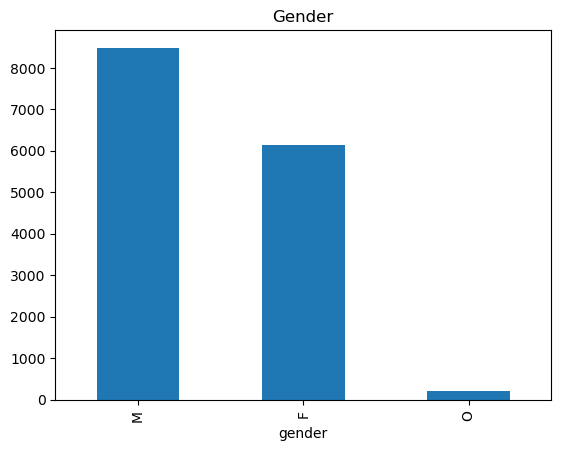

In [8]:
profile['gender'].value_counts().plot(kind='bar', title='Gender')
plt.show()

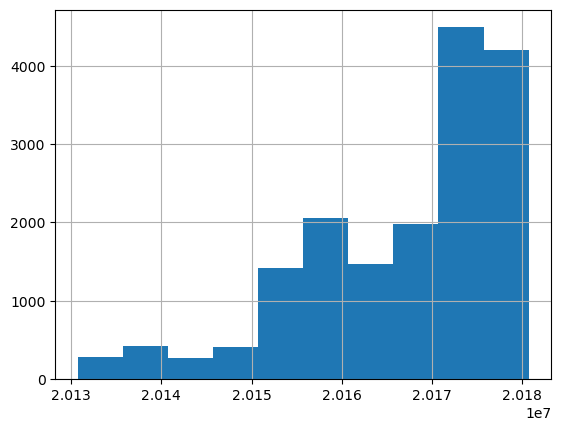

In [9]:
profile['became_member_on'].hist()
plt.show()

In [10]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


In [12]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


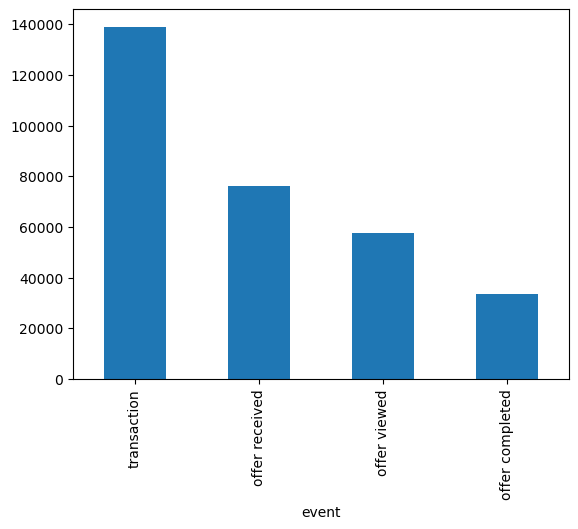

In [13]:
transcript['event'].value_counts().plot(kind='bar')
plt.show()

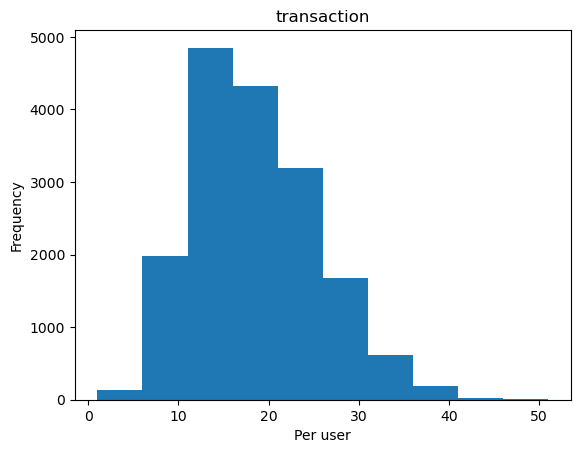

In [15]:
transcript.person.value_counts().plot(kind='hist', title='transaction')
plt.xlabel("Per user")
plt.show()

In [16]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [17]:
transcript.value.value_counts()

value
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 749.29}                                      1
{'amount': 78.85}                                       1
{'amount': 51.06}                                       1
{'amount': 1015.73}                                     1
{'amount': 40.83}                                       1
Name: count, Length: 5121, dtype: int64

In [18]:
def change_name(df, column_name):
    
    df= df.rename(columns = column_name)
    return df

In [19]:
column_name = {'difficulty':'min_spend_difficulty' , 'id':'offer_id', 'duration':'offer_time_duration', 'reward': 'given_offer_reward'}
portfolio_clean = change_name(portfolio, column_name )

In [20]:
portfolio_clean.head()

,given_offer_reward,channels,min_spend_difficulty,offer_time_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [21]:
def change_name_profile(df, profile_column_name):
    
    df= df.rename(columns = profile_column_name)
    return df

In [22]:
column_name_profile = {'id':'customer_id' , 'income':'customer_income'}
profile_clean = change_name_profile(profile, column_name_profile )

In [23]:
def cleanprofile(df):
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df.replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 40) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 41) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [24]:
profile_clean=cleanprofile(profile_clean)

/tmp/ipykernel_103/3440915832.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['age'].astype(int)
/tmp/ipykernel_103/3440915832.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
/tmp/ipykernel_103/3440915832.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [25]:
profile_clean.head()

,gender,customer_id,became_member_on,customer_income,Age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60
2,M,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,61-80
4,M,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,46-60


In [26]:
profile_clean.isnull().sum()

gender              0
customer_id         0
became_member_on    0
customer_income     0
Age_group           0
dtype: int64

In [27]:
def change_name_transcript(df, transcript_column_name):
    
    df= df.rename(columns = transcript_column_name)
    return df

In [28]:
column_name_transcript = {'person':'customer_id'}
transcript_clean_comp = change_name_transcript(transcript, column_name_transcript)

In [29]:
def transcript_clean(df):
    
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    df.fillna(0 , inplace=True)
    
    return df

In [30]:
transcript_clean_comp = transcript_clean(transcript_clean_comp)

In [31]:
transcript_clean_comp.head()

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [32]:
#Combine portfolio, profile & transcript data

def combine_data(portfolio,profile,transcript):
    combined_ppt = pd.merge(portfolio, transcript, on='offer_id')
    combined_ppt = pd.merge(combined_ppt, profile, on='customer_id') 
    return combined_ppt

In [33]:
combined_ppt = combine_data(portfolio_clean, profile_clean, transcript_clean_comp)

In [34]:
combined_ppt.head()

,given_offer_reward,channels,min_spend_difficulty,offer_time_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1e9420836d554513ab90eba98552d0a9,offer received,0,0.0,0.0,M,20170925,70000.0,20-45
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer received,0,0.0,0.0,F,20160711,30000.0,20-45
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,676506bad68e4161b9bbaffeb039626b,offer received,0,0.0,0.0,M,20170515,92000.0,20-45
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,fe8264108d5b4f198453bbb1fa7ca6c9,offer received,0,0.0,0.0,F,20161009,93000.0,61-80


In [35]:
combined_ppt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157503 entries, 0 to 157502
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   given_offer_reward    157503 non-null  int64  
 1   channels              157503 non-null  object 
 2   min_spend_difficulty  157503 non-null  int64  
 3   offer_time_duration   157503 non-null  int64  
 4   offer_type            157503 non-null  object 
 5   offer_id              157503 non-null  object 
 6   customer_id           157503 non-null  object 
 7   event                 157503 non-null  object 
 8   time                  157503 non-null  int64  
 9   money_gained          157503 non-null  float64
 10  money_spent           157503 non-null  float64
 11  gender                157503 non-null  object 
 12  became_member_on      157503 non-null  int64  
 13  customer_income       157503 non-null  float64
 14  Age_group             157503 non-null  object 
dtype

In [36]:
def combined_data_clean(df):
   
    category_var = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = category_var)
    df = df.drop('channels', axis=1).join(df.channels.str.join('|').str.get_dummies())
    

    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df['member_by_year'] = df['became_member_on'].apply(lambda x: x.year)
    df['member_by_month'] = df['became_member_on'].apply(lambda x: x.day)
    df.drop('became_member_on',axis=1, inplace=True)    
    

    offerid = df['offer_id'].unique().tolist()
    offermapping = dict(zip(offerid,range(len(offerid))) )
    df.replace({'offer_id': offermapping},inplace=True)
    
    customerid = df['customer_id'].unique().tolist()
    cust_mapping = dict( zip(customerid,range(len(customerid))) )
    df.replace({'customer_id': cust_mapping},inplace=True)
    
    scaler = MinMaxScaler() # default=(0, 1)
    numbering = ['customer_income', 'min_spend_difficulty', 'offer_time_duration', 'given_offer_reward', 'time', 'money_gained', 'money_spent']
    df[numbering] = scaler.fit_transform(df[numbering])
    
    df['event'] = df['event'].map({'offer_received':1, 'offer received':1, 'offer_viewed':2, 'offer viewed':2,'offer_completed':3, 'offer completed':3})
    
    return df

In [37]:
combined_datacleaned = combined_data_clean(combined_ppt)

/tmp/ipykernel_103/3903309853.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'offer_id': offermapping},inplace=True)
/tmp/ipykernel_103/3903309853.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'customer_id': cust_mapping},inplace=True)


In [38]:
combined_datacleaned.head()

,given_offer_reward,min_spend_difficulty,offer_time_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,member_by_year,member_by_month
0,1.0,0.5,0.571429,0,0,1,0.0,0.0,0.0,0.777778,...,False,False,True,False,1,1,1,0,2017,9
1,1.0,0.5,0.571429,0,1,1,0.0,0.0,0.0,0.444444,...,True,False,False,False,1,1,1,0,2017,25
2,1.0,0.5,0.571429,0,2,1,0.0,0.0,0.0,0.000000,...,True,False,False,False,1,1,1,0,2016,11
3,1.0,0.5,0.571429,0,3,1,0.0,0.0,0.0,0.688889,...,True,False,False,False,1,1,1,0,2017,15
4,1.0,0.5,0.571429,0,4,1,0.0,0.0,0.0,0.700000,...,False,False,True,False,1,1,1,0,2016,9


In [39]:
combined_datacleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157503 entries, 0 to 157502
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   given_offer_reward        157503 non-null  float64
 1   min_spend_difficulty      157503 non-null  float64
 2   offer_time_duration       157503 non-null  float64
 3   offer_id                  157503 non-null  int64  
 4   customer_id               157503 non-null  int64  
 5   event                     157503 non-null  int64  
 6   time                      157503 non-null  float64
 7   money_gained              157503 non-null  float64
 8   money_spent               157503 non-null  float64
 9   customer_income           157503 non-null  float64
 10  offer_type_bogo           157503 non-null  bool   
 11  offer_type_discount       157503 non-null  bool   
 12  offer_type_informational  157503 non-null  bool   
 13  gender_F                  157503 non-null  b

In [40]:
combined_datacleaned.shape

(157503, 26)

In [41]:

data = combined_datacleaned.drop('event', axis=1)
label = combined_datacleaned['event']


X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 126002 rows
Testing set: 31501 rows


In [42]:
def train_test(est_instance):
   
    train_predict =  (est_instance.fit(X_train, y_train)).predict(X_train)
    test_predict = (est_instance.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_predict)*100
    test_f1= fbeta_score(y_test, test_predict, beta = 0.5, average='micro' )*100
    model_name = est_instance.__class__.__name__
    
    return train_f1, test_f1, model_name

In [43]:
#Random Forest Classifier

est_instance_A = RandomForestClassifier(random_state = 10)
a_train_f1, a_test_f1, a_model = train_test(est_instance_A)

In [44]:
#KNeighboursClassifier (used to model f1 result metric)
est_instance_B = KNeighborsClassifier(n_neighbors = 5)
b_train_f1, b_test_f1, b_model = train_test(est_instance_B)

In [45]:
knn = {'Benchmark Model': [ b_model], 'train F1 score':[b_train_f1], 'test F1 score': [b_test_f1]}
benchmark = pd.DataFrame(knn)

In [46]:
#DecisionTreeClassifier

est_instance_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(est_instance_C)

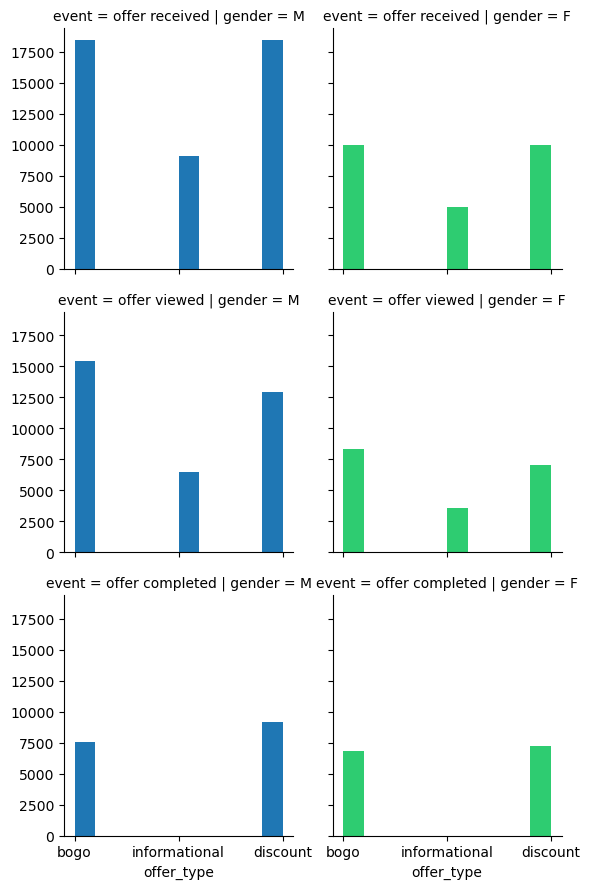

In [47]:
import seaborn as sns
d = {'color': ['C0', "#2ecc71"]}
g = sns.FacetGrid(combined_ppt[combined_ppt['gender'] != 'O'], row='event', col='gender', hue_kws=d, hue='gender')
g.map(plt.hist, 'offer_type')

In [48]:

model_metric = {'Model': [a_model, 'KNeighborsClassifier (Benchmark)', c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comparison = pd.DataFrame(model_metric)

In [49]:
comparison

,Model,train F1 score,test F1 score
0,RandomForestClassifier,93.955651,70.067617
1,KNeighborsClassifier (Benchmark),51.277757,29.033999
2,DecisionTreeClassifier,93.955651,84.686200


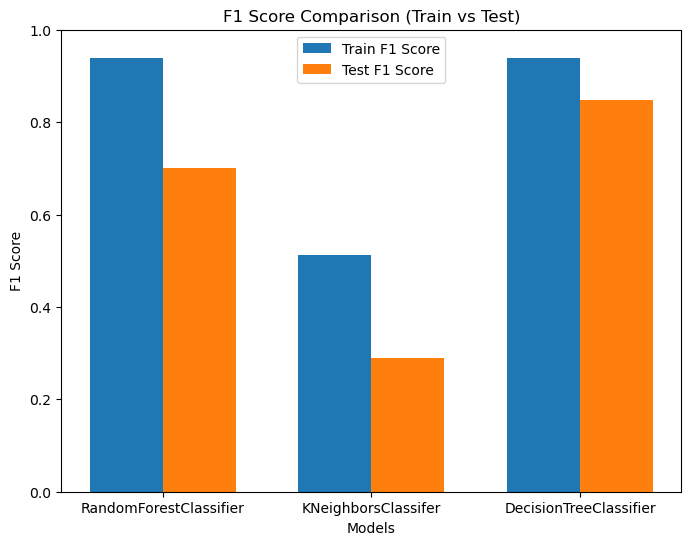

In [50]:
models = ['RandomForestClassifier', 'KNeighborsClassifer', 'DecisionTreeClassifier']

train_f1_scores = [0.93955651, 0.51277757, 0.93955651]
test_f1_scores = [0.70067617, 0.29033999, 0.84686200]

# Create bar plot
ind = np.arange(len(models))
width = 0.35
plt.figure(figsize=(8, 6))
plt.bar(ind - width/2, train_f1_scores, width, label='Train F1 Score')
plt.bar(ind + width/2, test_f1_scores, width, label='Test F1 Score')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Train vs Test)')
plt.xticks(ind, models)
plt.ylim(0, 1)  # Set y-axis limit
plt.legend()
plt.show()